In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tqdm import tqdm
from tensor_utils import outer, CPD1, Phi
rng = np.random.default_rng(14159)

In [2]:
# Set parameters
N_points = 50 # number of points
N_rep = 10 # number of repetition per point

beta = 0
epsilon = .2
c = np.array([1/6, 2/6, 3/6])
z = 1j
random_u = False # chose whether u^{(\ell)} is a generic vector or a singular vector

d = len(c) # order of the tensor
n = np.round(np.outer(np.logspace(1.9, 2.5, N_points), c)).astype(int) # growing tensor shapes
nn = np.sum(n, axis=1)

In [3]:
# Computations
bilinear = np.zeros((N_points, N_rep), dtype='complex')
trace = np.zeros((N_points, N_rep), dtype='complex')
for i in tqdm(range(N_points)):
    I = np.eye(nn[i])
    x, u = [], []
    for ell in range(d):
        # x[ell] is chosen uniformly at random on the unit sphere
        x.append(rng.standard_normal(n[i, ell]))
        x[ell] /= np.linalg.norm(x[ell])
        if random_u: # same for u[ell]
            u.append(rng.standard_normal(n[i, ell]))
            u[ell] /= np.linalg.norm(u[ell])
    P = beta*outer(x) # rank-one perturbation
    # Generate a, b to compute a^T Q b
    a, b = rng.standard_normal(nn[i]), rng.standard_normal(nn[i])
    a, b = a/np.linalg.norm(a), b/np.linalg.norm(b)
    # Generate A to compute Tr(Q A)/N
    A = rng.standard_normal((nn[i], nn[i]))
    A /= np.linalg.norm(A, ord=2)
    for rep in range(N_rep):
        N = rng.standard_normal(n[i]) # generate noise
        T = P+N/nn[i] # signal-plus-noise tensor
        B = rng.binomial(1, epsilon, size=n[i]) # Bernoulli mask
        if not random_u:
            _, u = CPD1(T*B)
        Qinv = Phi(T*B, u)-z*I
        bilinear[i, rep] = a@np.linalg.solve(Qinv, b)
        trace[i, rep] = np.trace(np.linalg.solve(Qinv, A))/nn[i]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


In [4]:
# Regressions
bilinear_var = np.var(bilinear, axis=1)
linreg_bilinear_var = linregress(np.log(nn), np.log(bilinear_var))
trace_var = np.var(trace, axis=1)
linreg_trace_var = linregress(np.log(nn), np.log(trace_var))

print("Power decay of variance")
print("Bilinear forms", linreg_bilinear_var.slope)
print("Traces", linreg_trace_var.slope)

Power decay of variance
Bilinear forms -2.4476069371462215
Traces -3.203556353568963


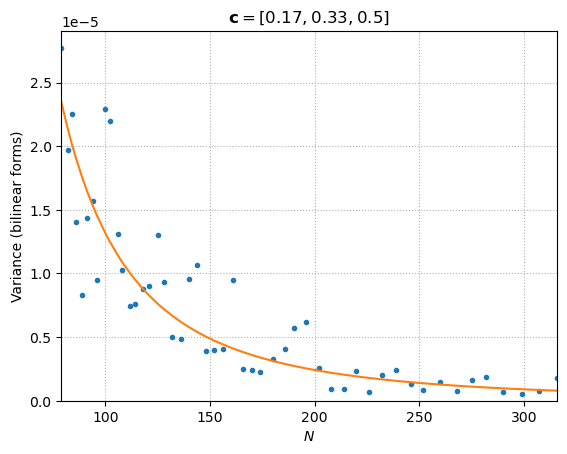

In [5]:
# Plot variance of bilinear forms
y_var = np.exp(linreg_bilinear_var.intercept)*nn**linreg_bilinear_var.slope
plt.plot(nn, bilinear_var, ls='', marker='.', color='C0')
plt.plot(nn, y_var, ls='-', color='C1')
plt.grid(ls=':')
plt.xlim(nn[0], nn[-1])
plt.ylim(bottom=0)
plt.xlabel("$N$")
plt.ylabel("Variance (bilinear forms)")
plt.title("$\\mathbf{{c}} = {{{}}}$".format(list(np.round(c, 2))))
plt.show()

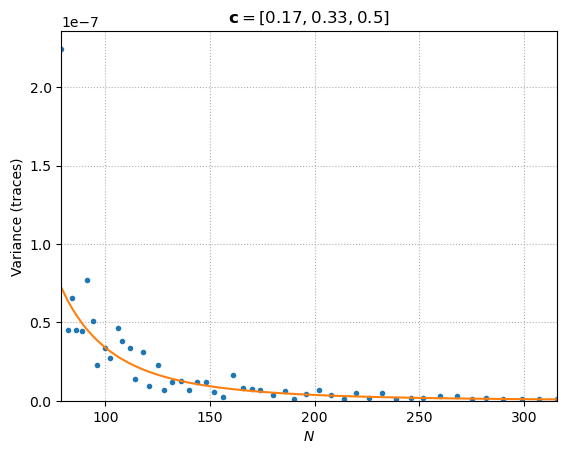

In [6]:
# Plot variance of traces
y_var = np.exp(linreg_trace_var.intercept)*nn**linreg_trace_var.slope
plt.plot(nn, trace_var, ls='', marker='.', color='C0')
plt.plot(nn, y_var, ls='-', color='C1')
plt.grid(ls=':')
plt.xlim(nn[0], nn[-1])
plt.ylim(bottom=0)
plt.xlabel("$N$")
plt.ylabel("Variance (traces)")
plt.title("$\\mathbf{{c}} = {{{}}}$".format(list(np.round(c, 2))))
plt.show()